In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import random
import math
import pickle
import os
import time
import psutil
from tqdm import tqdm
import statistics
from collections import Counter
from statistics import mode
import seaborn as sns
from tqdm import tqdm
from scipy.stats import multivariate_hypergeom
from scipy import stats
from termcolor import colored, cprint
from scipy.optimize import curve_fit
from sympy import Symbol, Integral
from PIL import Image
from openpyxl import Workbook
wb=Workbook()
ws=wb.active

In [2]:
#Preparation

def gaussian(x,constant,mean,std):
    f=constant*np.exp(-1*(((x-mean)/std)**2)/2)
    return f

def exponential(x,a,b,c,d):
    f=a*np.exp(b*x+c)+d
    return f

def quantile_cauchy(x,gam):
    f=math.tan(math.pi*(x-0.5))*gam
    return f

    
def N_t(t,N_ori,N_i,grad_var,lag_var):   # How population initially develop
  pop_num=N_i*math.exp(math.log(N_ori/N_i)*math.exp(-1*math.exp((grad_var*math.exp(1)/math.log(N_ori/N_i))*(lag_var-t)+1)))
  return math.floor(pop_num)


file=open(r'C:\Users\hpdkb\Desktop\Ev\previous\material_texts_for_coding\prime_set_with_only_numbers.txt',"r",encoding='UTF8')#saved_prime_numbers_location
n=file.read()
file.close()
n=n.split(',')
prime_set=[]
for i in n:
    prime_set.append(int(i))

prime_set_initial=prime_set[0:100]



In [3]:
def prime_factors(n):
    factors = []
    # Remove 2s first (even numbers)
    while n % 2 == 0:
        factors.append(2)
        n //= 2

    # Check odd numbers up to sqrt(n)
    i = 3
    while i * i <= n:
        while n % i == 0:
            factors.append(i)
            n //= i
        i += 2

    # If anything remains, it’s a prime
    if n > 2:
        factors.append(n)

    return factors

In [4]:
def color_yielding_function(algebra_type, resulting_algebra, objective_algebra):
    if algebra_type=='integer':
        return color
    
    if algebra_type=='matrix':
        resulting_algebra=np.array(resulting_algebra)
        el1=math.floor(127*((((det_obj-np.linalg.det(resulting_algebra))/det_obj)**2)+((trc_obj-np.trace(resulting_algebra))/trc_obj)**2))
        el2=math.floor(127*(((np.linalg.det(resulting_algebra)/det_obj)**2)+(np.trace(resulting_algebra)/trc_obj)**2))
        color=(el1,0,el2)
        
        return color

    if algebra_type=='two_array':
        color = "#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])
        
        return color


In [5]:
#initial value for the whole algorithm
def initial_function_maker(algebra_type, prime_set_initial, initial_algebra_array, s): 
  function={}
  summed_function={}
  summed_color_dict={}
  color_dict={}
  select_dict={}
  algebra_dict={}
  summed_algebra_dict={}
  initial_indice_array=[]
  initial_trait_number=len(initial_algebra_array)


  for i in range(initial_trait_number):
    initial_indice_array.append(prime_set[i])
  for i in initial_indice_array:
    function[i]=[(1/initial_trait_number), 1-(1/initial_trait_number)]
    algebra_dict[i]=initial_algebra_array[initial_indice_array.index(i)]
    select_dict[i]=algebra_specifics_selection(objective_algebra, algebra_type, algebra_dict[i],s, function)
    color_dict[i]=color_yielding_function(algebra_type, algebra_dict[i], objective_algebra)
        
  summed_color_dict, summed_algebra_dict = summed_dict_information_maker(0, function, summed_algebra_dict, algebra_dict, summed_color_dict, color_dict)
  summed_function=summed_function_information_maker(function, algebra_dict)
  color_dict[1]='#000000'   

    
  return summed_function, function, summed_color_dict, color_dict, select_dict, algebra_dict, summed_algebra_dict

In [6]:
def initial_function_info(function, prime_set_part, prime_index):
  x=list(function.keys())
  temp_ind=x
  temp_ind.sort()
  prime_index=prime_index+len(temp_ind)-1
  prime_set_part=list(set(prime_set_part)-set(temp_ind))

  return prime_index, prime_set_part


def inverse_permutation(a):
    b = np.arange(a.shape[0])
    b[a] = b.copy()

    return b


def discriminator(N, function):
  x=list(function.keys())
  temp_ind=x
  temp_ind.sort()

  for i in temp_ind:
    y=list(function[i])
    y=y[0]
    if y<(1/N):
      del function[i]


  return function


In [7]:
def conversion_function(select_dict, summed_algebra_dict):
    temporary_set=set({})
    converted_dict_for_s_value={}
    for i in list(summed_algebra_dict.keys()):
        temporary_set.add(i)

    for i in temporary_set:
        converted_dict_for_s_value[summed_algebra_dict[i]]=select_dict[i]

    return converted_dict_for_s_value

In [8]:
def algebra_dict_discriminator(function, algebra_dict):#obj: function에서 discriminator때문에 이미 소거된 algebra dict의 제거
    calgebra_dict=copy.deepcopy(algebra_dict)
    temporary_function_set=set(list(function.keys()))
    temporary_calgebra_dict_set=set(list(calgebra_dict.keys()))

    remaining_set=temporary_calgebra_dict_set-temporary_function_set

    for key in remaining_set:
        del algebra_dict[key]

    return algebra_dict

In [9]:
#select_dict={소수: s_value}
#function={소수, distn}
#summed_function={algebra: distn}
#summed_color_dict={algebra: color code}
#color_dict={소수: color code}
#algebra_dict={소수, algebra}
#obj: function 소수에 대응되는 algebra가 포함 안된 summed_function을 제거하는 것,,  
#for that, you need to compare algebra_dict and 


def summed_dict_information_maker(t, function, summed_algebra_dict, algebra_dict, summed_color_dict, color_dict):
    #temp_algebra_dict=choose_only_exisisting_algebra_dictionary(function, algebra_dict)
    copy_algebra_dict=copy.deepcopy(algebra_dict)
    #print("algeb_dict:",copy_algebra_dict)
    temporary_copy_algebra_dict={}
    temporary_dict={}
    summed_function={}


    for i in list(copy_algebra_dict.keys()):
        if type(copy_algebra_dict[i])==int:
            temporary_copy_algebra_dict[i]=[i]
        else:
            temporary_copy_algebra_dict[i]=np.array(list(list(row) for row in algebra_dict[i]))
   
    #start = time.perf_counter()    
    for i in list(copy_algebra_dict.keys()):#소수들
        temporary_array=[i]
        for j in list(copy_algebra_dict.keys()):
            if i>j:#duplicate counting prevention
                #print("algebra_dict[i]: ",algebra_dict[i])
                if type(copy_algebra_dict[i])==int:
                    if temporary_copy_algebra_dict[i]==temporary_copy_algebra_dict[j]: #if the results are same from different sources(or, prime numbers)
                        temporary_array.append(j) #those are collected   
                    
                else:
                    if (temporary_copy_algebra_dict[i]==temporary_copy_algebra_dict[j]).all(): #if the results are same from different sources(or, prime numbers)
                        temporary_array.append(j) #those are collected   
        if type(algebra_dict[i])==np.ndarray:
            tuple_matrix = tuple(tuple(row) for row in algebra_dict[i])
            temporary_dict[tuple_matrix]=temporary_array
        else:
            temporary_dict[algebra_dict[i]]=temporary_array    #특정한 algebra에 대응되는 가능한 모든 소수들의 list가 temporary_array
    #end = time.perf_counter()
    #print("t:",t," second part", f"Elapsed time: {end - start:.4f} seconds")   



    if list(summed_color_dict.keys())==[]:
        for prime in list(function.keys()):
            summed_color_dict[algebra_dict[prime]]=color_dict[prime]

    else:
        remainder_clr=set(list(temporary_dict.keys()))-set(list(summed_color_dict.keys()))

        for algebra in remainder_clr:
            summed_color_dict[algebra]=color_dict[temporary_dict[algebra][0]] #temporary_dict[algebra]는 array고, 걔네는 모두 같은 color 값 갖기 때문에 그냥 가장 먼저 등장한 값 [0] 반영

    if list(summed_algebra_dict.keys())==[]:
        summed_algebra_dict=algebra_dict

    else:
        temp1=list(summed_algebra_dict.keys())
        temp2=list(function.keys())
        remainder=set(temp2)-set(temp1)
        #print("\nremainder: ",remainder)
        for i in remainder:
            summed_algebra_dict[i]=algebra_dict[i]

   
    return summed_color_dict, summed_algebra_dict


def summed_function_information_maker(function, algebra_dict):
    calgebra_dict=copy.deepcopy(algebra_dict)
    temporary_dict={}
    summed_function={}
    algebra_dict=algebra_dict_discriminator(function, calgebra_dict)

      
    for i in list(algebra_dict.keys()):#소수들
        temporary_array=[i]
        for j in list(algebra_dict.keys()):
            if i>j:#duplicate counting prevention
                if algebra_dict[i]==algebra_dict[j]: #if the results are same from different sources(or, prime numbers)
                    temporary_array.append(j) #those are collected   
        if algebra_dict[i] in list(temporary_dict.keys()):
            sub_temporary_array=temporary_dict[algebra_dict[i]]
            temporary_dict[algebra_dict[i]]=list(set(sub_temporary_array+temporary_array))
        if algebra_dict[i] not in list(temporary_dict.keys()):
            temporary_dict[algebra_dict[i]]=temporary_array
     

         
    #temporary_dict={algebra:[corresponding primes]} #the new ones
    for a in list(temporary_dict.keys()):

        summed_function_value=0
        for b in list(temporary_dict[a]):
            summed_function_value+=function[b][0]

        summed_function[a]=[summed_function_value, 1-summed_function_value]
    #print("\n1temporary_dict: ",temporary_dict)

    return summed_function

In [10]:
def s_value_zeroer(function, select_dict,N,s):
    # Ensure consistent key order and numeric data
    established_function_key_array=[]
    for key in list(function.keys()):
        if function[key][0]>(1/(N*s)):
            established_function_key_array.append(key)
    
    crit_values = [float(select_dict[k]) for k in established_function_key_array]
    min_val = min(crit_values)

    
    key_array=list(function.keys())
    values = [float(select_dict[k]) for k in key_array]

    
    # Subtract the min safely and return mapping
    temporary_s_value_dictionary = {k: (v - min_val) for k, v in zip(key_array, values)}
    return temporary_s_value_dictionary


In [11]:
def mutation(summed_algebra_dict, objective_algebra, algebra_type, algebra_dict, N, m, s, function, color_dict, prime_index, prime_set_part, prime_set_array, prime_sets, select_dict):
    
  x=list(function.keys())
  temp_ind=x
  temp_ind.sort()
  det_for_loop=0
  if summed_algebra_dict!=[]:
    algebra_dict=choose_only_exisisting_algebra_dictionary(function, summed_algebra_dict)

  for i in temp_ind:
    y=list(function[i])
    y=y[0]
    if N*m*y>=1:
      exceed_num=math.floor(N*m*y)
      float_num=N*m*y-exceed_num
      function[i]=[y-exceed_num*(1/N),1-(y-exceed_num*(1/N))]
      for j in range(exceed_num):
        
        if prime_set_part==[]:
            
          if prime_set_array==[]:
            det_for_loop=-1
            return function, color_dict, prime_index, prime_set_part, prime_set_array, det_for_loop, select_dict
        
          else:
            prime_set_array.remove(prime_set_array[0])
            prime_set_part=copy.deepcopy(prime_sets[prime_set_array[0]])
            next_prime=prime_set_part[0]
            
        else:
          next_prime=prime_set_part[0]
    
        n=i*next_prime
        function[n]=[1/N,1-(1/N)]
        color, mutated_algebra=algebra_specifics_mutation(objective_algebra, algebra_type, algebra_dict[i])
        algebra_dict[n]=mutated_algebra
        prime_set_part.remove(next_prime)
        prime_set_part.sort()
        prime_index+=1
          
        color_dict[n]=color  

        select_dict[n]=algebra_specifics_selection(objective_algebra, algebra_type, algebra_dict[n],s, function)

    
      y=list(function[i])[0]
      alpha=1
      if N*y!=0:
        alpha=1-(1/(N*y))

        a=np.array([[1,0],[0,1]])
        b=np.array([[alpha,0],[1-alpha,1]])
        c=np.array([[1,1/N],[0,1-1/N]])

        crit=float_num
        r=random.random()  

        if r<crit:
            
          if prime_set_part==[]:
            
            if prime_set_array==[]:
              det_for_loop=-1
              return function, color_dict, prime_index, prime_set_part, prime_set_array, det_for_loop, select_dict
        
            else:
              prime_set_array.remove(prime_set_array[0])
              prime_set_part=copy.deepcopy(prime_sets[prime_set_array[0]])
              next_prime=prime_set_part[0]  
            
          else:
            next_prime=prime_set_part[0]
        
          n=i*next_prime
          color, mutated_algebra=algebra_specifics_mutation(objective_algebra, algebra_type, algebra_dict[i])
          algebra_dict[n]=mutated_algebra
            
          f=np.array(function[i])
          f=b@f
          f=f/np.sum(f)
          f=f.tolist()
          function[i]=f
          function[n]=[0,1]
          g=np.array(function[n])
          g=c@g
          g=g/np.sum(g)
          g=g.tolist()
          function[n]=g
          prime_set_part.remove(next_prime)
          prime_set_part.sort()
          prime_index+=1
 
          color_dict[n]=color  

          select_dict[n]=algebra_specifics_selection(objective_algebra, algebra_type, algebra_dict[n],s, function)

            
    else:
      alpha=1
      if N*y!=0:
        alpha=1-(1/(N*y))

      a=np.array([[1,0],[0,1]])
      b=np.array([[alpha,0],[1-alpha,1]])
      c=np.array([[1,1/N],[0,1-1/N]])

      crit=N*m*y
      r=random.random()
    
      if r<crit:
            
        if prime_set_part==[]:
            
          if len(prime_set_array)==1:
            det_for_loop=-1
            return function, color_dict, prime_index, prime_set_part, prime_set_array, det_for_loop, select_dict
        
          else:
            prime_set_array.remove(prime_set_array[0])
            prime_set_part=copy.deepcopy(prime_sets[prime_set_array[0]])
            next_prime=prime_set_part[0]
            
        else:
          next_prime=prime_set_part[0]

        n=i*next_prime
        color, mutated_algebra=algebra_specifics_mutation(objective_algebra, algebra_type, algebra_dict[i])
        algebra_dict[n]=mutated_algebra
        
        f=np.array(function[i])
        f=b@f
        f=f/np.sum(f)
        f=f.tolist()
        function[i]=f
        function[n]=[0,1]
        g=np.array(function[n])
        g=c@g
        g=g/np.sum(g)
        g=g.tolist()
        function[n]=g
        prime_set_part.remove(next_prime)
        prime_set_part.sort()
        prime_index+=1
          
        color_dict[n]=color  

        select_dict[n]=algebra_specifics_selection(objective_algebra, algebra_type, algebra_dict[n],s, function)
      
        
       
  return algebra_dict, function, color_dict, prime_index, prime_set_part, prime_set_array, det_for_loop, select_dict

In [12]:
def potential(summed_function, algebra_type, algebra_dict, function,select_dict,s):
  temp_fit={}
  temp_pot={}
  temp_rate={}

  x=list(function.keys())
  temp_ind=x
  temp_ind.sort()


  if algebra_type=='RPS':
      f=2
      temp_set=set(list(summed_function.keys()))
      for i in temp_ind:
          if algebra_dict[i]=='R':
              if 'P' not in temp_set and 'S' not in temp_set:
                  temp_fit[i]=1+select_dict[i]
              if 'P' not in temp_set and 'S' in temp_set:
                  temp_fit[i]=1+select_dict[i]+f*s*(summed_function['S'][0])
              if 'S' not in temp_set and 'P' in temp_set:
                  temp_fit[i]=1+select_dict[i]+f*s*(-summed_function['P'][0])
              if 'P' in temp_set and 'S' in temp_set:
                  temp_fit[i]=1+select_dict[i]+f*s*(summed_function['S'][0]-summed_function['P'][0])

          if algebra_dict[i]=='P':
              if 'R' not in temp_set and 'S' not in temp_set:
                  temp_fit[i]=1+select_dict[i]
              if 'S' not in temp_set and 'R' in temp_set:
                  temp_fit[i]=1+select_dict[i]+f*s*(summed_function['R'][0])
              if 'R' not in temp_set and 'S' in temp_set:
                  temp_fit[i]=1+select_dict[i]+f*s*(-summed_function['S'][0])
              if 'R' in temp_set and 'S' in temp_set:
                  temp_fit[i]=1+select_dict[i]+f*s*(summed_function['R'][0]-summed_function['S'][0])

          if algebra_dict[i]=='S':
              if 'P' not in temp_set and 'R' not in temp_set:
                  temp_fit[i]=1+select_dict[i]
              if 'R' not in temp_set and 'P' in temp_set:
                  temp_fit[i]=1+select_dict[i]+f*s*(summed_function['P'][0])
              if 'P' not in temp_set and 'R' in temp_set:
                  temp_fit[i]=1+select_dict[i]+f*s*(-summed_function['R'][0])
              if 'P' in temp_set and 'R' in temp_set:
                  temp_fit[i]=1+select_dict[i]+f*s*(summed_function['P'][0]-summed_function['R'][0])
  else:
      for i in temp_ind:
          temp_fit[i]=1+select_dict[i]

  
  weight=0
  
  for i in temp_ind:
      y=list(function[i])
      weight=weight+(float(temp_fit[i])*(float(y[0])))

  for i in temp_ind:
      temp_pot[i]=temp_fit[i]/weight

  for i in temp_ind:
      pot=float(temp_pot[i])
      y=list(function[i])

      if pot==1:
          pot_bar=1
      else:
          x=y[0]
          a=(1-pot*x)
          b=(1-x)
          pot_bar=a/b

      A=np.array([[pot,0],[0,pot_bar]])

      y_np=np.array(y)
      y_np=A@y_np
      z=y_np.tolist()
      function[i]=z

 
  return function

In [13]:
def drift(function, N, N_ori, dynamic_mode): #drift D operator information could be explicitly expressed, but to reduce the computation complexity, only the result after D was expressed here.
  h={}
  ch_function=dict(sorted(function.items()))
  ftns=ch_function.values()
  x=list(function.keys())
  temp_ind=x
  temp_ind.sort()
  length=len(temp_ind)

  for i in temp_ind:
    h[i]=math.floor(float(ch_function[i][0])*N*2)

  allocation_bound=list(h.values())
  
  seed = random.randint(0,2**32-1)
  gen = np.random.Generator(np.random.PCG64(seed))
    
  if dynamic_mode=='on':
    sigmoid_proportion=(1+(1/(math.exp(-1*math.tan(math.pi*(N/N_ori)/2))+1)))/2
    if N/N_ori<0.9:
      randomness=random.uniform(1,1+0.2*math.exp(-1*N/N_ori))
    else:
      randomness=random.uniform(1-0.2*math.exp(-1*math.tan(math.pi*(N/N_ori)/2)),1+0.2*math.exp(-1*math.tan(math.pi*(N/N_ori)/2)))
    
    new_allocation_bound=[]
    for i in allocation_bound:
      new_allocation_bound.append(math.floor(i*randomness*sigmoid_proportion))
    allocation_bound=np.array(new_allocation_bound)
    ordered_values=gen.multivariate_hypergeometric(allocation_bound, N)
    ordered_values=list(ordered_values)
  
  else:
    ordered_values=gen.multivariate_hypergeometric(allocation_bound, N)
    ordered_values=list(ordered_values)

  for i in range(length):
    ordered_values[i]=ordered_values[i]/N

  Y=[]
  for i in range(length):
    Y.append(i)

  for i in range(length):
    Y[i]=[ordered_values[i],1-ordered_values[i]]

  H=dict(zip(temp_ind,(Y)))
  
  return H

In [14]:
def choose_only_exisisting_algebra_dictionary(function, summed_algebra_dict):
    temp_algebra_dict={}
    for prime in list(function.keys()):
        temp_algebra_dict[prime]=summed_algebra_dict[prime]

    return temp_algebra_dict

In [15]:
#The main function
def logos(iter, crit_iter, objective_algebra, algebra_type, summed_function, summed_color_dict, summed_algebra_dict, algebra_dict, prime_set, generation, function, N, m, s, color_dict, N_i, grad_var,lag_var,dynamic_mode, select_dict):
  prime_sets={}
  prime_set_array=[]

  j=0
  while j in range(len(prime_set)):
    prime_sets[math.floor(j/10000)]=prime_set[j:j+10000]
    j=j+10000
  
  prime_set_array=list(prime_sets.keys())
  history=[]
  algebra_dict=algebra_dict
  color_dict=color_dict
  select_dict=select_dict
  whole_history_by_prime={}  
  whole_history_summed={}
  mean_fit_increase_history={}
  prime_index=0
  prime_set_part=copy.deepcopy(prime_sets[prime_set_array[0]])
  prime_index, prime_set_part=initial_function_info(function, prime_set_part, prime_index)
  prime_set_part.sort()
  N_ori=N
  fixation_tracking_array=[]
  first_gen_tracking_array=[generation+1]
  
  for t in range(0,generation+1):

    if dynamic_mode=='on':
        N=N_t(t,N_ori,N_i,grad_var,lag_var)
 
    algebra_dict, function, color_dict, prime_index, prime_set_part, prime_set_array, det_for_loop, select_dict = mutation(summed_algebra_dict, objective_algebra, algebra_type, algebra_dict, N, m, s, function, color_dict, prime_index, prime_set_part, prime_set_array, prime_sets, select_dict)
    #temp_algebra_dict=choose_only_exisisting_algebra_dictionary(function, algebra_dict)
    #print("t",t,"\nalgebra_dict",algebra_dict)
    copy_summed_algebra_dict=copy.deepcopy(summed_algebra_dict)  
    summed_color_dict, summed_algebra_dict=summed_dict_information_maker(t, function, copy_summed_algebra_dict, algebra_dict, summed_color_dict, color_dict)
    
    if det_for_loop==-1:
        generation=t
        print("prime_set_shortage for t:",t)
        break
    
    function=discriminator(N, function)
    summed_function= summed_function_information_maker(function, algebra_dict)
    temporary_zeroed_s_value_dict=s_value_zeroer(function, select_dict,N,s)
    function=potential(summed_function, algebra_type, summed_algebra_dict, function,temporary_zeroed_s_value_dict,s)
    function=discriminator(N, function)
    function=drift(function, N, N_ori, dynamic_mode)
    function=discriminator(N, function)
    summed_function= summed_function_information_maker(function, algebra_dict)
    whole_history_by_prime[t]=function  
    
    whole_history_summed[t]=summed_function
    if algebra_type=='two_array':
        if iter<=crit_iter and t%100==0:
            print("t:",t)
            #print("summed_function: ", summed_function)
            print("function: ",function)
            #draw_the_two_array_set(summed_function, algebra_dict, s)

  converted_dict_for_s_value_dict=conversion_function(select_dict, summed_algebra_dict)  
  #print("whole_history_by_prime: ",whole_history_by_prime)
  #print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
  #print("algebra_dict: ",algebra_dict)
  #print("\n\n\n\n")
  #print("whole_history_summed: ",whole_history_summed)
  #print("\n\n")    
  #print("last_ftn: ", whole_history_by_prime[generation])
  #print("\n\n\n\n")  
  #print("last_summed_ftn: ", whole_history_summed[generation])
  #print("\n\n")    
  #print("last_algebra: ",list(whole_history_summed[generation].keys()))
  #print("\nsummed_color_dict: ",summed_color_dict)
  #print("\nsummed_algebra_dict: ",summed_algebra_dict)  
  #print("\nselect_dict: ", select_dict)
  #print("\nconverted_dict_for_s_value_dict: ",converted_dict_for_s_value_dict)  
  return generation, whole_history_by_prime, whole_history_summed, color_dict, summed_color_dict, prime_set_array, algebra_dict, summed_algebra_dict 


In [16]:
#For drawing Muller Plot
#whole_history_summed={t:{algebra:distn}} 
def mat_for_plot(whole_history,generation):
    whole_index=whole_index_finder(whole_history,generation) # returns the collection of whole algebra throughout all generations
    Y=copy.deepcopy(whole_history) # copy of whole_history_summed
    original_history=copy.deepcopy(Y) #copy of whole_history_summed
    aligned_history={} 
    concatenated_aligned_history={}
    proportion_density_history={}
    new_2D_whole_history={}
    time_interval_dictionary={}
    new_line_whole_history=new_line_whole_history_making_function(whole_history, generation, whole_index)
    #new_line_whole_history returns {algebra: [portion array for each generation when the algebra existed]}

    for t in range(generation):
      aligned_history[t]=align_analysis(original_history, aligned_history, t)
#returns {generation: [existing algebra array]},, note that the algebra array has specific order to reflect the origin of mutation
    for t in range(generation):
      concatenated_aligned_history[t]=concatenate_function(original_history, aligned_history, t)
#returns {generation: {algebra: [distn]}}
    for t in range(generation):
      proportion_density_history[t]=density_giving_function(concatenated_aligned_history, t)
#returns {generation:{algebra: accumulated proportion for that algebra}}    
    print("pdh done")
    new_2D_whole_history=new_2D_whole_history_making_function(proportion_density_history, generation, whole_index)

    time_interval_dictionary = time_interval(generation, whole_history,whole_index)


    return new_line_whole_history, proportion_density_history, new_2D_whole_history, time_interval_dictionary


def concatenate_function(original_history, aligned_history, t): #returns {generation: {algebra: [distn]}}
  A=original_history[t]
  B=list(aligned_history[t]) #this would return "the keys" for the t generation's aligned history
  C={}

  for element in B:
    C[element]=A[element]

  return C #for some particular generation t, C={key in aligned_history[t]:distn for that key at the original_history[t]}

def density_giving_function(concatenated_aligned_history,t): #returns {generation:{algebra: accumulated proportion for that algebra}}    
  proportion_density={0:0}
#concatenated_aligned_history[t]={key in aligned_history[t]:distn for that key at the original_history[t]}
  A=concatenated_aligned_history[t].keys()
  temp_set=(list(A)) #list for keys for concatenated_algined_history for t generation, 
  #which is composed of key values for aligned history [t]

  for i in list(concatenated_aligned_history[t]): #keys in aligned_history[t]
    temp_proportion_density={}
    temp_proportion_density[i]=concatenated_aligned_history[t][i][0] #the probability value
    if temp_set.index(i)==0:
      proportion_density[i]=temp_proportion_density[i]+proportion_density[0]
    else:
      n=temp_set[temp_set.index(i)-1]
      proportion_density[i]=temp_proportion_density[i]+proportion_density[n]

  return proportion_density

def whole_index_finder(whole_history,generation): # returns the collection of whole algebra in an ordered sequence

  A=set({})
  for t in range(generation):
    A=A.union(set(whole_history[t].keys())) #collection of all algebra throughout the generation

  whole_index=list(A)
  whole_index.sort() #ordering 

  return whole_index

def align_algorithm(temp_prior, prior, new_born): # returns the aligned array that reflects "the sequnce" of the origination of mutation
#temp_prior is t-1 generation일 때의 aligned hisotry의 algebra array
  element_dictionary={}

  for element in new_born:
    A=[]
    for i in prior:
      if element%i==0: #if the (new) element is a multiple of preexisting number i in prior array,
        A.append(i) #append that preexisting number 'i's to array A
    a=max(A) #a is a maximum value among that 'i's 
    element_dictionary[element]=a #element dictionary is composed with {element: maximum i that divides the element (i.e., a)}
    n=temp_prior.index(element_dictionary[element]) #n is an index for a
    m=temp_prior.index(element) #m is an index for element
    temp_prior.insert(n,element) #insert 'element' to the temp_prior array at the index n
    del temp_prior[m+1] #delete the array for m+1

  return temp_prior

def align_analysis(original_history, aligned_history, t): #returns {generation: [existing algebra array]},, note that the algebra array has specific order to reflect the origin of mutation

  if t==0:
    A=copy.deepcopy(original_history[0]) #original_history[0]-> generation=0 일 때의 initial {algebra:distn}
    temp_present=list(A.keys()) #only algebras
    temp_present.reverse() #chaning the order of the algebras
    present=temp_present 

    return present # if t=0, returns the algebras of the initial state with inverse order (to reflect how the algebras would be represented in the Muller plot)

  else: #when t>0
    A={}
    A=copy.deepcopy(original_history[t])
    current=list(A.keys()) #t generation일 때의 original hisotry의 algebra array

    B={}
    B=copy.deepcopy(aligned_history[t-1])
    prior=list(B) #t-1 generation일 때의 aligned hisotry의 algebra array

    new_born=set(current)-set(prior) #the algebra element that only t generation have compared to t-1
    diminished=set(prior)-set(current) #the algebra element that only t-1 generation have compared to t

    temp_prior=copy.deepcopy(prior) #copy of prior, type: list

    if new_born!=set({}): #if there exists a new algebra

      for new in list(new_born): 
        temp_prior.append(new) #add those new algebra to the set of prior algebras

      temp_present=align_algorithm(temp_prior, prior, new_born) #returns the aligned algebra list that reflects the origin of the mutation

      if diminished != set({}): #if there exists an diminished algebra
        for old in list(diminished):
          temp_present.remove(old) #remove from the array

        present=temp_present

      else:
        present=temp_present

      return present

    else: #when there is no new algebra
      temp_present=temp_prior
      if diminished != set({}):
        for old in list(diminished):
          temp_present.remove(old)

        present=temp_present

      else:
        present=temp_prior
      return present

def time_interval(generation, whole_history,whole_index): #returns {algebra: times t that that algebra existed}
  time_interval_dict={}

  for i in whole_index: #whole algebras
    time_interval=[]
    for t in range(generation):
      if i in (whole_history[t].keys()): #if the algebra i is in the t generation's dictionary's key values
        time_interval.append(t) #add that t to the time_interval
    time_interval_dict[i]=time_interval #{algebra: times t that that algebra existed}

  return time_interval_dict

def new_2D_whole_history_making_function(proportion_density_history,generation, whole_index):
# proportion_density_history={}
  new_2D_whole_history={}
  print("2D_making_ftn started")
  for i in whole_index:
    new_part=[]
    for t in range(generation):
      if i in list(proportion_density_history[t].keys()):
        new_part.append(proportion_density_history[t][i])

    new_2D_whole_history[i]=new_part

  return new_2D_whole_history

def new_line_whole_history_making_function(whole_history, generation, whole_index):
#whole_history={t:{algebra:distn}}
  new_line_whole_history={}
  print("1D_making_ftn started")
  for i in whole_index:
    new_line_part=[]
    for t in range(generation):
      if i in list(whole_history[t].keys()):
        new_line_part.append(float(list((whole_history[t][i]))[0]))

    new_line_whole_history[i]=new_line_part

  return new_line_whole_history #{algebra: 


def drawing_one_dim(title, info_with_title, draw_directory_for_iteration_detail, new_line_whole_history, time_interval_dictionary, summed_color_dict, summed_algebra_dict, N, m, s, iter):
  plt.rcParams['font.family']='Arial'
  plt.figure(figsize = (15,7))
  plt.xticks(size=15)
  plt.yticks(size=15)
  plt.xlabel('generation',fontsize=25,labelpad=5)  
  plt.ylabel('proportion',fontsize=25,labelpad=20)
  print("actual_1D_started")
  
  for i in new_line_whole_history:
    #print("\nsummed_algebra_dict[i]: ",summed_algebra_dict[i])
    #print("summed_color_dict[summed_algebra_dict[i]]: ",summed_color_dict[summed_algebra_dict[i]])
    clr=summed_color_dict[summed_algebra_dict[i]]

    #plt.plot(time_interval_dictionary[i],new_line_whole_history[i],color=clr,linestyle='-') # could express the border lines in the Muller plot, but not recommended to use
    a=max(new_line_whole_history[i])
    plt.plot(time_interval_dictionary[i],new_line_whole_history[i],color=clr,linestyle='-')

  plt.savefig(str(draw_directory_for_iteration_detail)+'no title one dim.png')
  plt.rcParams['font.family']='Arial'
  plt.title('one dim with_'+str(info_with_title))
  plt.savefig(str(draw_directory_for_iteration_detail)+'one dim without legend.png')  
  plt.legend(loc=10,fontsize="8")
  plt.savefig(str(draw_directory_for_iteration_detail)+'one dim.png')

  plt.close()
  
def drawing_two_dim(title, info_with_title, draw_directory_for_iteration_detail, new_2D_whole_history, time_interval_dictionary, generation, proportion_density_history, summed_color_dict, summed_algebra_dict, N, m, s, iter):
  index_set=list(new_2D_whole_history.keys())

  plt.rcParams['font.family']='Arial'
  plt.figure(figsize = (15,7))
  plt.xticks(size=15)
  plt.yticks(size=15)
  plt.xlabel('generation',fontsize=25,labelpad=5)
  plt.ylabel('proportion',fontsize=25,labelpad=20)
  print("actual_2D_started")


  time_range=[]

  for t in range(generation):
    time_range.append(t)


  for t in range(generation-1):
    temp_ind1=list(proportion_density_history[t].keys())
    temp_ind2=list(proportion_density_history[t+1].keys())

    for i in temp_ind1:
      if i==temp_ind1[-1]:
          break

      else:
        next_ind1=temp_ind1.index(i)+1
        next_key1=temp_ind1[next_ind1]

        if i in temp_ind2:
          if next_key1 in temp_ind2:
            next_ind2=temp_ind2.index(i)+1
            if next_ind2<len(temp_ind2)-1:
              next_key2=temp_ind2[next_ind2]
              plt.fill([time_range[t],time_range[t],time_range[t+1],time_range[t+1]],[proportion_density_history[t][i], proportion_density_history[t][next_key1],proportion_density_history[t+1][next_key2], proportion_density_history[t+1][i]],color=summed_color_dict[summed_algebra_dict[next_key1]])
            if next_ind2==len(temp_ind2)-1:
              plt.fill([t,t,t+1],[proportion_density_history[t][i],proportion_density_history[t][next_key1],proportion_density_history[t+1][temp_ind2[-2]]],color=summed_color_dict[summed_algebra_dict[next_key1]])
          else:
            plt.fill([t,t,t+1],[proportion_density_history[t][i],proportion_density_history[t][next_key1],proportion_density_history[t+1][i]],color=summed_color_dict[summed_algebra_dict[next_key1]])

        else:
          temp_num=0
          while i not in temp_ind2:
            next_ind3=temp_ind1.index(i)-1
            next_key3=temp_ind1[next_ind3]
            i=temp_ind1[next_ind3]
            temp_num=i
          plt.fill([t,t,t+1],[proportion_density_history[t][i],proportion_density_history[t][next_key1],proportion_density_history[t+1][temp_num]],color=summed_color_dict[summed_algebra_dict[next_key1]])  

  
  plt.rcParams['font.family']='Arial'
  plt.savefig(str(draw_directory_for_iteration_detail)+'no title two dim.png')
  plt.title(str(info_with_title))
  plt.savefig(str(draw_directory_for_iteration_detail)+'two dim.png')

  plt.close()

In [17]:
def directory_making_ftn(directory, title, info_with_title):
    
 
    new_directory=str(directory)+str(title)+'/'
    os.mkdir(new_directory)
    f = open(str(new_directory)+'core_variables.txt', 'w')
    with open(str(new_directory)+'core_variables.txt', 'w') as f:
        f.write(str(info_with_title))
    f.close()  

    directory_for_total=str(new_directory)+'total/'
    os.mkdir(directory_for_total)
    directory_for_iteration_detail=str(new_directory)+'iteration_detail/'
    os.mkdir(str(directory_for_iteration_detail))
    os.mkdir(str(directory_for_iteration_detail)+'logos_data/')
    os.mkdir(str(directory_for_iteration_detail)+'mat_for_plot_data/')
    
    return new_directory, directory_for_total, directory_for_iteration_detail

In [18]:
def information_from_logos(objective_algebra, algebra_type, summed_function, summed_color_dict, summed_algebra_dict, algebra_dict, draw_iter_array, directory_for_total, directory_for_iteration_detail, regime, title, info_with_title, directory, prime_set, generation,function,N,m,s,iter, color_dict, N_i, grad_var, lag_var, dynamic_mode, select_dict):      
 
  if regime=='concurrent':
    crit_iter=draw_iter_array[0]    
  if regime=='successional':
    crit_iter=draw_iter_array[1]    
  if regime=='between':
    crit_iter=draw_iter_array[2]    
  if regime=='drift':
    crit_iter=draw_iter_array[3]      


  logos_data= logos(iter, crit_iter, objective_algebra, algebra_type, summed_function, summed_color_dict, summed_algebra_dict, algebra_dict, prime_set, generation, function, N, m, s, color_dict, N_i, grad_var,lag_var,dynamic_mode, select_dict)

  generation=logos_data[0]
  whole_history_by_prime=logos_data[1]
  whole_history_summed=logos_data[2]
  color_dict=logos_data[3]
  summed_color_dict=logos_data[4]
  prime_set_array=logos_data[5]
  algebra_dict=logos_data[6]
  summed_algebra_dict=logos_data[7]  
    
  
  if iter<=crit_iter: #crit_iter means how many Muller plots to be drawn
    draw_directory_for_iteration_detail=str(directory_for_iteration_detail)+str(iter)+'/'
    os.mkdir(draw_directory_for_iteration_detail)
    mat_for_plot_data= mat_for_plot(whole_history_by_prime,generation) #as a whole
    #mat_for_plot_data= mat_for_plot(whole_history_by_prime,generation) #individually
      
    new_line_whole_history=mat_for_plot_data[0]
    proportion_density_history=mat_for_plot_data[1]
    new_2D_whole_history=mat_for_plot_data[2]
    time_interval_dictionary=mat_for_plot_data[3]
    print("mat_for-plot done")
    
    drawing_one_dim(title, info_with_title, draw_directory_for_iteration_detail, new_line_whole_history, time_interval_dictionary, summed_color_dict, summed_algebra_dict, N, m, s, iter) #as a whole
    #drawing_one_dim(title, info_with_title, draw_directory_for_iteration_detail, new_line_whole_history, time_interval_dictionary, summed_color_dict, algebra_dict, N, m, s, iter) #individually 
    print("one_dim_done")
    
    drawing_two_dim(title, info_with_title, draw_directory_for_iteration_detail, new_2D_whole_history, time_interval_dictionary, generation, proportion_density_history, summed_color_dict, summed_algebra_dict, N, m, s, iter) #as a whole
    #drawing_two_dim(title, info_with_title, draw_directory_for_iteration_detail, new_2D_whole_history, time_interval_dictionary, generation, proportion_density_history, summed_color_dict, algebra_dict, N, m, s, iter) #individually
    print("two_dim_done")

  return logos_data



In [19]:
def statistical_info(objective_algebra, algebra_type, initial_algebra_array, draw_iter_array, iteration_size, core_variable_array, directory, prime_set, prime_set_initial, N_i,grad_var,lag_var,dynamic_mode):
  for i in range(len(core_variable_array)):
    N=core_variable_array[i][0]
    m=core_variable_array[i][1]
    s=core_variable_array[i][2]
    generation=core_variable_array[i][3]
    initial_trait_number=core_variable_array[i][4]
    regime=core_variable_array[i][5]
    
    title = 'algebra_type_'+str(algebra_type)+', N_'+str("{:.2e}".format(N))+', m_'+str("{:.2e}".format(m))+', delta s_'+str("{:.2e}".format(s))+', g_'+str(generation)+', i_t_n_'+str(initial_trait_number)+', itr_'+str(iteration_size)+', regime_'+str(regime)
    info_with_title='algebra_type_'+str(algebra_type)+', N_'+str("{:.2e}".format(N))+', m_'+str("{:.2e}".format(m))+', delta s_'+str("{:.2e}".format(s))+',\n g_'+str(generation)+', initial_n_'+str(initial_trait_number)+', itr_'+str(iteration_size)+', regime_'+str(regime)

    new_directory, directory_for_total, directory_for_iteration_detail=directory_making_ftn(directory, title, info_with_title)
 

    
    time_when_evolution_reached_the_objective_algebra_array=[]
    the_success_record_array=[]


    #bookmark
    for iter in tqdm(range(iteration_size)):
        start = time.perf_counter()
        summed_function, function, summed_color_dict, color_dict, select_dict, algebra_dict, summed_algebra_dict = initial_function_maker(algebra_type, prime_set_initial, initial_algebra_array, s)
        information_from_logos_data=information_from_logos(objective_algebra, algebra_type, summed_function, summed_color_dict, summed_algebra_dict, algebra_dict, draw_iter_array, directory_for_total, directory_for_iteration_detail, regime, title, info_with_title, directory, prime_set, generation,function,N,m,s,iter, color_dict, N_i, grad_var, lag_var, dynamic_mode, select_dict)

        whole_history_summed=information_from_logos_data[2]
        time_recorded=the_time_record(N,s,whole_history_summed, objective_algebra, algebra_type)
        print("the_time_record:", time_recorded)
        if time_recorded>0:
            time_when_evolution_reached_the_objective_algebra_array.append(the_time_record(N,s,whole_history_summed, objective_algebra, algebra_type))
    
        the_success_record_array.append(the_success_record(whole_history_summed, objective_algebra, algebra_type))
        print("the_success_record:", the_success_record(whole_history_summed, objective_algebra, algebra_type))
        end = time.perf_counter()
        print("iter:",iter," the_time_passed", f"Elapsed time: {end - start:.4f} seconds")

    if time_when_evolution_reached_the_objective_algebra_array!=[]:
        print("time_when_evolution_reached_the_objective_algebra_array:",time_when_evolution_reached_the_objective_algebra_array)
        positive_array=choose_positive_elements(time_when_evolution_reached_the_objective_algebra_array)
        p, t_stdev, t_average, t_max=the_time_info(time_when_evolution_reached_the_objective_algebra_array)
        print("iteration_size:",iteration_size)
        print("p:", p)
        print("t_stdev:", t_stdev)  
        print("t_average:", t_average)
        print("t_max:", t_max)
        sns.histplot(time_when_evolution_reached_the_objective_algebra_array, kde=True, stat="density", bins=50)
        plt.title("Distribution of Data")
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.show()

        distribution_analyzer(time_when_evolution_reached_the_objective_algebra_array)

    print("the_success_record_array",the_success_record_array)
    success_rate=the_success_info(the_success_record_array)
    print("success_rate:",success_rate)
      
    try:
        ram_info = psutil.virtual_memory()
        print(f"Total: {ram_info.total / 1024 / 1024 / 1024:.2f} GB")
        print(f"Available: {ram_info.available / 1024 / 1024 / 1024:.2f} GB")
        print(f"Used: {ram_info.used / 1024 / 1024 / 1024:.2f} GB")
        print(f"Percentage usage: {ram_info.percent}%")
    except FileNotFoundError:
        print("Ram info not available on this system")



In [20]:
import scipy.stats as stats

def distribution_analyzer(time_when_evolution_reached_the_objective_algebra_array):
    # List of candidate distributions
    data=time_when_evolution_reached_the_objective_algebra_array
    distributions = ['norm', 'expon', 'lognorm', 'gamma', 'beta', 'uniform']
    
    best_fit = None
    best_p = 0  # p-value from goodness-of-fit test
    results = []
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        
        # Fit distribution to data
        params = dist.fit(data)
        
        # Perform the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=params)
        
        results.append((dist_name, p))
        
        if p > best_p:
            best_p = p
            best_fit = dist_name
    
    print(f"Best fit distribution: {best_fit} (p = {best_p:.4f})")
    print("All results:")
    for name, p in results:
        print(f"{name}: p = {p:.4f}")

In [21]:
def choose_positive_elements(time_when_evolution_reached_the_objective_algebra_array):
    positive_array=[]
    for time in time_when_evolution_reached_the_objective_algebra_array:
        if time>0:
            positive_array.append(time)

    return positive_array

In [22]:
from scipy.stats import shapiro

def tuple_to_np(alg):
    return np.array(alg)

def np_to_tuple(alg):
    to_list_info=alg.tolist()
    converted_matrix=tuple(tuple(x) for x in to_list_info)
    return converted_matrix

#aaa    
def the_time_record(N,s,whole_history_summed, objective_algebra, algebra_type):
    cwhole_history_summed=copy.deepcopy(whole_history_summed)
    for t in list(cwhole_history_summed.keys()):
        
        for i in list(cwhole_history_summed[t].keys()):
            if algebra_type=='matrix':
                if cwhole_history_summed[t][i][0]>1/(N*s) and np.trace(tuple_to_np(i))==np.trace(np.array(objective_algebra)) and np.linalg.det(tuple_to_np(i))==np.linalg.det(np.array(objective_algebra)):
                    return t
            else:
                if cwhole_history_summed[t][i][0]>1/(N*s) and (tuple_to_np(i)==np.array(objective_algebra)).all():
                    return t
                
                if cwhole_history_summed[t][i][0]>0.98 and (tuple_to_np(i)==np.array([((0,2),)])).all():
                    return -1

                
#bookmark
    return -1000000


def the_time_info(time_when_evolution_reached_the_objective_algebra_array):
    t_sum=0
    i=0
    for t in time_when_evolution_reached_the_objective_algebra_array:
        if t>0:
            t_sum+=t
            i+=1
    if i==0:
        t_average=-1000000
    else:
        t_average=t_sum/i
    t_max=max(time_when_evolution_reached_the_objective_algebra_array)
    t_stdev = statistics.stdev(time_when_evolution_reached_the_objective_algebra_array)
    stat, p = shapiro(time_when_evolution_reached_the_objective_algebra_array)

    return p, t_stdev, t_average, t_max
    

def the_success_record(whole_history_summed, objective_algebra, algebra_type):

    cwhole_history_summed=copy.deepcopy(whole_history_summed)
    last_generation=list(cwhole_history_summed.keys())[-1]
    the_last_algebra=list(cwhole_history_summed[last_generation].keys())
    
    
    for i in the_last_algebra:
        if algebra_type=='matrix':
            if np.trace(tuple_to_np(i))==np.trace(np.array(objective_algebra)) and np.linalg.det(tuple_to_np(i))==np.linalg.det(np.array(objective_algebra)):
                return 1
        else:
            print("the_algebra: ", i)
            if (tuple_to_np(i)==np.array(objective_algebra)).all():
                return 1

    return 0

def the_success_info(the_success_record_array):
    total_len=len(the_success_record_array)
    sum_success=sum(the_success_record_array)

    success_rate=sum_success/total_len

    return success_rate
    

In [23]:
def integer_algebra_specifics_mutation(objective_algebra, original_algebra):
    original_algebra=original_algebra

    r=random.random()
    if 0<r<=0.6:
        resulting_algebra=original_algebra+1
    if 0.6<r<=0.8:
        resulting_algebra=original_algebra+3
    if 0.8<r<=1:
        resulting_algebra=original_algebra*6
    
    '''
    if 0<r<=0.4:
        resulting_algebra=original_algebra+1
    if 0.4<r<=0.8:
        resulting_algebra=original_algebra+2
    if 0.8<r<=0.9:
        resulting_algebra=original_algebra*2
    if 0.9<r<=1:
        resulting_algebra=original_algebra*11
        '''
    

    color=color_yielding_function('integer', resulting_algebra, objective_algebra)
    new_algebra=resulting_algebra

    return color, new_algebra

    
#bookmark
def integer_algebra_specifics_selection(objective_algebra, algebra_of_interest,s):
    algebra=int(algebra_of_interest)
    s_value=s

    obj_algebra=int(objective_algebra)
    prime_obj_array=list(prime_factors(obj_algebra))

    if algebra<10:
        s_value=algebra*s/3
    if 10<algebra<100:
        s_value=algebra*s/10
    if 100<algebra:
        s_value=algebra*s/50


    #완성하기, prime_obj_array와 prime_array 비교하여!
    count_2=0
    count_3=0
    count_obj=Counter(prime_obj_array)
    #print("algebra:", algebra)
    if algebra!=0:
        prime_array=list(prime_factors(algebra))
        count=Counter(prime_array)      
        for key in list(count.keys()):
            if key==2:
                if count[key]<=4:
                    count_2=count[key]

            if key==3:
                if count[key]<=4:
                    count_3=count[key]

        total_count=min(count_2,count_3)
        s_value+=2*total_count*s
                   

    if abs(algebra-obj_algebra)<=50:
        s_value=algebra*s/50
        s_value+=2*4*s
        s_value+=s*(algebra-(obj_algebra-50))*(2/3)

    if algebra>obj_algebra:
        s_value=-1*s
##bookmark

    '''
    for key in list(count.keys()):
        if key=11:
            if count[key]<=3:
                s_value+=1.2*count[key]*s
    if abs(algebra-obj_algebra)<=50:
        s_value+=1.2*3*s
        s_value+=math.exp(-((algebra-obj_algebra)/50)**2)*s*10

                
    '''

    '''simplest:

    if algebra>obj_algebra:
        s_value=-1*s
    
    else:
        s_value=algebra*s*(1/10)
        
    '''
    #print("s_value: ",s_value)
    return s_value

In [24]:
def modulo_algebra_specifics_mutation(objective_algebra, original_algebra):
    temporary_original_algebra=np.array(list(list(row) for row in original_algebra))
    r=random.random()
    if r<=0.05:
        resulting_algebra=temporary_original_algebra+np.array([[1,0,0,0]])
    if 0.05<r<=0.1:
        resulting_algebra=temporary_original_algebra+np.array([[2,0,0,0]])
    if 0.2<r<=0.25:
        resulting_algebra=temporary_original_algebra+np.array([[0,1,0,0]])
    if 0.25<r<=0.3:
        resulting_algebra=temporary_original_algebra+np.array([[0,2,0,0]])
    if 0.4<r<=0.45:
        resulting_algebra=temporary_original_algebra+np.array([[0,0,1,0]])
    if 0.45<r<=0.5:
        resulting_algebra=temporary_original_algebra+np.array([[0,0,2,0]])
    if 0.6<r<=0.65:
        resulting_algebra=temporary_original_algebra+np.array([[0,0,0,1]])
    if 0.65<r<=0.7:
        resulting_algebra=temporary_original_algebra+np.array([[0,0,0,2]])
    if 0.8<r<=0.9:
        resulting_algebra=temporary_original_algebra+np.array([[1,1,0,0]])   
    if 0.1<r<=0.2:
        resulting_algebra=temporary_original_algebra+np.array([[1,0,1,0]])
    if 0.3<r<=0.4:
        resulting_algebra=temporary_original_algebra+np.array([[1,0,0,1]])
    if 0.5<r<=0.6:
        resulting_algebra=temporary_original_algebra+np.array([[0,1,1,0]])
    if 0.7<r<=0.8:
        resulting_algebra=temporary_original_algebra+np.array([[0,1,0,1]])
    if 0.9<r<=1:
        resulting_algebra=temporary_original_algebra+np.array([[0,0,1,1]])

    modulo_array=[]
    for i in resulting_algebra[0]:
        modulo_array.append(i%4)

    modulo_array=[modulo_array]

    color=color_yielding_function('modulo', resulting_algebra, objective_algebra)
    new_algebra=tuple(tuple(row) for row in modulo_array)

    return color, new_algebra

    

def modulo_algebra_specifics_selection(objective_algebra, algebra_of_interest,s):
    temp_algebra=list(list(row) for row in algebra_of_interest)        
    
    x1=(-(temp_algebra[0][0]-objective_algebra[0])**2)/3+3
    x2=(-(temp_algebra[0][1]-objective_algebra[1])**2)/3+3
    x3=(-(temp_algebra[0][2]-objective_algebra[2])**2)/3+3
    x4=(-(temp_algebra[0][3]-objective_algebra[3])**2)/3+3

    s_value_1=(x1+x2+x3+x4)*s
    s_value_2=(x1*x2*x3*x4)*s

    s_value=max(s_value_1, s_value_2)
    
    return s_value


In [25]:
def RPS_algebra_specifics_mutation(objective_algebra, original_algebra):
    
    r=random.random()
    if r<=(1/3):
        resulting_algebra='R'
    if (1/3)<r<=(2/3):
        resulting_algebra='P'
    if (2/3)<r<=1:
        resulting_algebra='S'
        
    color = "#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])

    return color, resulting_algebra
    

def RPS_algebra_specifics_selection(objective_algebra, algebra_of_interest, s, function):
    s_value=s

    return s_value


In [26]:
def list_algebra_specifics_mutation(objective_algebra, original_algebra):
    temporary_original_algebra=list(list(row) for row in original_algebra)
    #print("temporary_original_algebra: ",temporary_original_algebra)
    ta=[] #temporary_array
    for i in temporary_original_algebra[0]:
        ta.append(i)
    r=random.random()
    c=random.choice([0,1,2,3])
    #print("c",c)
    


    if c==0:
        if r<=0.3:
            #print("\n0.3r",r)
            resulting_algebra=temporary_original_algebra+np.array([[1,0,0,0]])
        if 0.3<r<=0.5:
            #print("\n0.5r",r)
            resulting_algebra=temporary_original_algebra+np.array([[-0.5,0,0,0]])
        if 0.5<r<=0.9:
            #print("\n0.9r",r)
            resulting_algebra=temporary_original_algebra+np.array([[2,0,0,0]])
    
        if 0.9<r<=1:
            #print("\n1r",r)
            resulting_algebra=temporary_original_algebra


    if c==1:
        if ta[0]>=5:
            if r<=0.3:
                resulting_algebra=temporary_original_algebra+np.array([[0,1,0,0]])
            if 0.3<r<=0.5:
                resulting_algebra=temporary_original_algebra+np.array([[0,-0.5,0,0]])
            if 0.5<r<=0.9:
                resulting_algebra=temporary_original_algebra+np.array([[0,3,0,0]])
            if 0.9<r<=1:
                resulting_algebra=temporary_original_algebra
        if ta[0]<5:
            resulting_algebra=temporary_original_algebra

    
    if c==2:
        if ta[1]>=5:
            if r<=0.3:
                resulting_algebra=temporary_original_algebra+np.array([[0,0,1,0]])
            if 0.3<r<=0.5:
                resulting_algebra=temporary_original_algebra+np.array([[0,0,-0.5,0]])
            if 0.5<r<=0.9:
                resulting_algebra=temporary_original_algebra+np.array([[0,0,2,0]])
            if 0.9<r<=1:
                resulting_algebra=temporary_original_algebra
        
        else:
            resulting_algebra=temporary_original_algebra
                
    if c==3:
        if ta[2]>=5:
            if r<=0.3:
                resulting_algebra=temporary_original_algebra+np.array([[0,0,0,1]])
            if 0.3<r<=0.5:
                resulting_algebra=temporary_original_algebra+np.array([[0,0,0,-0.5]])
            if 0.5<r<=0.9:
                resulting_algebra=temporary_original_algebra+np.array([[0,0,0,2]])
            if 0.9<r<=1:
                resulting_algebra=temporary_original_algebra
        else:
            resulting_algebra=temporary_original_algebra


    color=color_yielding_function('list', resulting_algebra, objective_algebra)
    
    new_algebra=tuple(tuple(row) for row in resulting_algebra)

    return color, new_algebra
    

def list_algebra_specifics_selection(objective_algebra, algebra_of_interest,s):
    temp_algebra=list(list(row) for row in algebra_of_interest)
    #print(temp_algebra)
    
    x1=(-(temp_algebra[0][0]-objective_algebra[0])**2)/7+7
    x2=(-(temp_algebra[0][1]-objective_algebra[1])**2)/6+7
    x3=(-(temp_algebra[0][2]-objective_algebra[2])**2)/5+10
    x4=(-(temp_algebra[0][3]-objective_algebra[3])**2)/5+9

    s_value_1=(x1+x2+x3+x4)*s
    s_value_2=(x1*x2*x3*x4)*s

    s_value=max(s_value_1, s_value_2)

    return s_value


In [27]:
def rgb_to_hex(r, g, b):
    if not all(0 <= val <= 255 for val in (r, g, b)):
        raise ValueError("RGB values must be between 0 and 255")
    return "#{:02X}{:02X}{:02X}".format(r, g, b)

In [28]:
def color_yielding_function(algebra_type, resulting_algebra, objective_algebra):
    if algebra_type=='integer':
        
        el1=(((resulting_algebra-objective_algebra)/objective_algebra)**2)
        if (resulting_algebra/objective_algebra)<1:
            el2=((resulting_algebra/objective_algebra)**2)
            color=[math.floor(255*el1),math.floor(255*(el1+el2)/2),math.floor(255*el2)]
            hex_clr=rgb_to_hex(color[0],color[1],color[2])

        else:
            hex_clr=rgb_to_hex(255,255,255)
            

        return hex_clr
    
    if algebra_type=='matrix':
        obj_algebra=np.array(objective_algebra)
        det_obj=np.linalg.det(obj_algebra)
        trc_obj=np.trace(obj_algebra)
        resulting_algebra=np.array(resulting_algebra)
        det_alg=abs(np.linalg.det(resulting_algebra))
        trc_alg=abs(np.trace(resulting_algebra))
        #print("obj_algebra",obj_algebra)
        #print("det_obj",det_obj)
        #print("trc_obj",trc_obj)
        #print("resulting_algebra",resulting_algebra)
        #print("det_alg",det_alg)
        #print("trc_obj",trc_alg)
        el1=math.floor(127*((((det_obj-det_alg)/max(det_alg,det_obj,det_obj-det_alg))**2)+((trc_obj-trc_alg)/max(trc_alg,trc_obj,trc_obj-trc_alg))**2))
        el2=math.floor(127*(((det_alg/max(det_alg,det_obj,det_obj-det_alg))**2)+(trc_alg/max(trc_alg,trc_obj,trc_obj-trc_alg))**2))
        color=[el1,math.floor((el1+el2)/2),el2]
        #print("color:",color)
        hex_clr=rgb_to_hex(color[0],color[1],color[2])
        
        return hex_clr

    
    if algebra_type=='list':
        el1=0
        el2=0
        for i in len(resulting_algebra[0]):
            el1=+(((resulting_algebra[0][i]-objective_algebra[i])/objective_algebra[i])**2)/len(resulting_algebra[0])
            el2=+((resulting_algebra[0][i]/objective_algebra[i])**2)/len(resulting_algebra[0])
    
        color=[math.floor(255*el1),math.floor(255*(el1+el2)/2),math.floor(255*el2)]
        hex_clr=rgb_to_hex(color[0],color[1],color[2])
        
        return hex_clr        


    
    if algebra_type=='modulo':
        el1=0
        el2=0
        for i in len(modulo_array):
            el1=+(((modulo_array[i]-objective_algebra[i])/objective_algebra[i])**2)/len(modulo_array)
            el2=+((modulo_array[i]/objective_algebra[i])**2)/len(modulo_array)
        
        color=[math.floor(255*el1),math.floor(255*(el1+el2)/2),math.floor(255*el2)]
        hex_clr=rgb_to_hex(color[0],color[1],color[2])
        
        return hex_clr   

In [29]:
def objective_analysis(objective_algebra, algebra_type):
    if algebra_type=='integer':
        return objective_algebra[0]
    
    if algebra_type=='matrix':
        objected_value_array=[]
        for i in len(objective_algebra):
            for j in len(objective_algebra):
                objected_value_array.append(objective_algebra[i][j])
        return objected_value_array
    
    if algebra_type=='list':
        objected_value_array=[]
        for i in len(objective_algebra):
            objected_value_array.append(objective_algebra[i])
        return objected_value_array
    
    if algebra_type=='modulo':
        objected_value_array=[]
        for i in len(objective_algebra):
            objected_value_array.append(objective_algebra[i])
        return objected_value_array
    
    if algebra_type=='RPS':
        return objective_algebra[0]
        

In [30]:
def algebra_specifics_mutation(objective_algebra, algebra_type, original_algebra):
    if algebra_type=='integer':
        return integer_algebra_specifics_mutation(objective_algebra, original_algebra)
    if algebra_type=='matrix':
        return matrix_algebra_specifics_mutation(objective_algebra, original_algebra)
    if algebra_type=='list':
        return list_algebra_specifics_mutation(objective_algebra, original_algebra)
    if algebra_type=='modulo':
        return modulo_algebra_specifics_mutation(objective_algebra, original_algebra)
    if algebra_type=='RPS':
        return RPS_algebra_specifics_mutation(objective_algebra, original_algebra)
    if algebra_type=='two_array':
        return two_array_mutation(objective_algebra, original_algebra)
    if algebra_type=='cyclic':
        return cyclic_mutation(objective_algebra, original_algebra)
        
def algebra_specifics_selection(objective_algebra, algebra_type, algebra_of_interest, s, function):
    if algebra_type=='integer':
        return integer_algebra_specifics_selection(objective_algebra, algebra_of_interest, s)
    if algebra_type=='matrix':
        return matrix_algebra_specifics_selection(objective_algebra, algebra_of_interest, s)
    if algebra_type=='list':
        return list_algebra_specifics_selection(objective_algebra, algebra_of_interest, s)
    if algebra_type=='modulo':
        return modulo_algebra_specifics_selection(objective_algebra, algebra_of_interest, s)
    if algebra_type=='RPS':
        return RPS_algebra_specifics_selection(objective_algebra, algebra_of_interest, s, function)
    if algebra_type=='two_array':
        return two_array_selection(algebra_of_interest, s)
    if algebra_type=='cyclic':
        return cyclic_selection(objective_algebra, original_algebra)

In [31]:
def matrix_algebra_specifics_mutation(objective_algebra, original_algebra):
    temporary_original_algebra=list(list(row) for row in original_algebra)
    r=random.random()
    obj_algebra=np.array(objective_algebra)
    det_obj=np.linalg.det(obj_algebra)
    trc_obj=np.trace(obj_algebra)
   
    if 0.025<r<=0.05:
        resulting_algebra=temporary_original_algebra+np.array([[0,2],[0,1]])
    if 0.225<r<=0.25:
        resulting_algebra=temporary_original_algebra+np.array([[0,1],[0,2]])
    if 0.425<r<=0.45:
        resulting_algebra=temporary_original_algebra+np.array([[2,0],[1,0]])
    if 0.625<r<=0.65:
        resulting_algebra=temporary_original_algebra+np.array([[1,0],[2,0]])
    if r<=0.025:
        resulting_algebra=temporary_original_algebra+np.array([[0,1],[0,1]])
    if 0.2<r<=0.225:
        resulting_algebra=temporary_original_algebra+np.array([[1,0],[1,0]])
    if 0.4<r<=0.425:
        resulting_algebra=temporary_original_algebra+np.array([[1,0],[3,0]])
    if 0.6<r<=0.625:
        resulting_algebra=temporary_original_algebra+np.array([[0,3],[0,1]])
    if 0.05<r<=0.1:
        resulting_algebra=temporary_original_algebra+np.array([[1,0],[0,0]])
    if 0.25<r<=0.3:
        resulting_algebra=temporary_original_algebra+np.array([[0,1],[0,0]])
    if 0.45<r<=0.5:
        resulting_algebra=temporary_original_algebra+np.array([[0,0],[1,0]])
    if 0.65<r<=0.7:
        resulting_algebra=temporary_original_algebra+np.array([[0,0],[0,1]])
    if 0.85<r<=0.9:
        resulting_algebra=temporary_original_algebra+np.array([[-1,0],[0,0]])   
    if 0.15<r<=0.2:
        resulting_algebra=temporary_original_algebra+np.array([[0,-1],[0,0]])
    if 0.35<r<=0.4:
        resulting_algebra=temporary_original_algebra+np.array([[0,0],[-1,0]])
    if 0.55<r<=0.6:
        resulting_algebra=temporary_original_algebra+np.array([[0,0],[0,-1]])
    if 0.8<r<=0.85:
        resulting_algebra=temporary_original_algebra+np.array([[1,0],[0,1]])   
    if 0.1<r<=0.15:
        resulting_algebra=temporary_original_algebra+np.array([[-1,0],[0,-1]])
    if 0.3<r<=0.35:
        resulting_algebra=temporary_original_algebra+np.array([[0,-1],[-1,0]])
    if 0.5<r<=0.55:
        resulting_algebra=temporary_original_algebra+np.array([[0,1],[1,0]])
    if 0.7<r<=0.75:
        resulting_algebra=temporary_original_algebra+np.array([[2,0],[0,2]])
    if 0.75<r<=0.8:
        resulting_algebra=temporary_original_algebra+np.array([[-2,0],[0,-2]])
    if 0.9<r<=0.95:
        resulting_algebra=temporary_original_algebra+np.array([[0,-2],[-2,0]])
    if 0.95<r<=1:
        resulting_algebra=temporary_original_algebra+np.array([[0,2],[2,0]])
    
    

    color=color_yielding_function('matrix', resulting_algebra, objective_algebra)
    
    new_algebra=tuple(tuple(row) for row in resulting_algebra)

    return color, new_algebra

#new_algebra와 objective algebra의 관계를 통한 color의 return    

def matrix_algebra_specifics_selection(objective_algebra, algebra_of_interest,s):
    temp_algebra=list(list(row) for row in algebra_of_interest)
    algebra=np.array(temp_algebra)
    obj_algebra=np.array(objective_algebra)
    
    det=np.linalg.det(algebra)
    det_obj=np.linalg.det(obj_algebra)
    trc=np.trace(algebra)
    trc_obj=np.trace(obj_algebra)
    s_value=s

    x=-(det-det_obj)**2/det_obj+det_obj
    y=-(trc-trc_obj)**2/trc_obj+trc_obj

    s_value=(x+y)*s_value

    return s_value



In [32]:
def two_array_mutation(objective_algebra, original_algebra):
    temporary_original_algebra=np.array(list(list(row) for row in original_algebra))
    r=random.random()

    if r<=0.5:
        resulting_algebra=temporary_original_algebra+np.array([[1,0]])

    if 0.5<r<=1:
        resulting_algebra=temporary_original_algebra+np.array([[0,1]])
    

    color=color_yielding_function('two_array', resulting_algebra, objective_algebra)
    new_algebra=tuple(tuple(row) for row in resulting_algebra)

    return color, new_algebra

def two_array_selection(algebra_of_interest,s):
    temp_algebra=list(list(row) for row in algebra_of_interest)        
    array=[[0,0,0],[1,0,0.5],[0,1,0.8],[2,0,2.5],[0,2,2],[1,1,0],[2,1,1.8],[1,2,2.2],[2,2,1.8],[3,0,0],[3,1,0],[3,2,0],[3,3,0],[2,3,0],[1,3,0],[0,3,0]]

    x=temp_algebra[0][0]
    y=temp_algebra[0][1]

    for element in array:
        if element[0]==x:
            if element[1]==y:
                s_value=element[2]*s

    return s_value


def draw_the_two_array_set(summed_function, algebra_dict, s):
    algebra_list=list(summed_function.keys())

    values=[]
    for algebra in algebra_list:
        values.append(summed_function[algebra][0])
    #print("values",values) #bkm

    x_array=[]
    y_array=[]
    z_array=[]

    
    array=[[0,0,0],[1,0,0.5],[0,1,0.8],[2,0,2.5],[0,2,2],[1,1,0],[2,1,1.8],[1,2,2.2],[2,2,1.8],[3,0,0],[3,1,0],[3,2,0],[3,3,0],[2,3,0],[1,3,0],[0,3,0]]

    for element in array:
        x_array.append(element[0])
        y_array.append(element[1])
        z_array.append(element[2])

    size_array=the_size_decider(values)
    #print("size_array", size_array) #bkm
    
    new_array=two_array_up_pyramid(x_array, y_array, z_array)
    the_vertices=make_the_vertices(summed_function, new_array)
    draw_the_pillars(new_array, the_vertices, size_array)

def the_size_decider(values):
    size_array=[]

    for value in values:
        if value<0.1:
            size_array.append(0)
        if value>=0.1:
            size_array.append(value*10)
        
    
    return size_array
    
def two_array_down_pyramid():
    x_array=[]
    y_array=[]
    z_array=[]
    set1=set({})
    for x in range(4):
        for y in range(4):
            set1.add(tuple([x,y,abs(x)+abs(y)]))
            set1.add(tuple([x,-y,abs(x)+abs(-y)]))
            set1.add(tuple([-x,y,abs(-x)+abs(y)]))
            set1.add(tuple([-x,-y,abs(-x)+abs(-y)]))

    array=[list(t) for t in set1]
    for element in array:
        x_array.append(element[0])
        y_array.append(element[1])
        z_array.append(element[2])

    
    return array, x_array, y_array, z_array

def two_array_s(array,x,y):
    for element in array:
        if element[0]==x:
            if element[1]==y:
                s_value=element[2]

    return s_value

def two_array_up_pyramid(x_array, y_array, z_array):
    cx_array=copy.deepcopy(x_array)
    cy_array=copy.deepcopy(y_array)
    new_z_array=[]
    new_array=[]
    cz_array=copy.deepcopy(z_array)
    z_max=max(cz_array)
    i=0
    for element in z_array:
        new_z_array.append(z_max-element)
        new_array.append([x_array[i],y_array[i], z_max-element+0.4])
        i+=1

    return new_array


In [33]:
import plotly.graph_objs as go
import numpy as np
import plotly.io as pio

pio.renderers.default = 'browser'  # or 'browser' if needed

x, y, z = 0, 0, 5
width = 1.0
h = width / 2

def create_cuboid_with_top(x, y, z, width=0.8, face_color='lightblue', edge_color='blue'):
    h = width / 2
    verts = np.array([
        [x - h, y - h, 0],  # 0 bottom
        [x + h, y - h, 0],  # 1
        [x + h, y + h, 0],  # 2
        [x - h, y + h, 0],  # 3
        [x - h, y - h, z],  # 4 top
        [x + h, y - h, z],  # 5
        [x + h, y + h, z],  # 6
        [x - h, y + h, z],  # 7
    ])

    # Correct triangle indices — 2 per face × 6 faces = 12 triangles
    i = [0, 0, 4, 4, 0, 0, 1, 1, 2, 2, 3, 3]
    j = [1, 2, 5, 6, 1, 4, 5, 2, 6, 3, 7, 0]
    k = [2, 3, 6, 7, 5, 5, 6, 6, 7, 7, 4, 4]

    mesh = go.Mesh3d(
        x=verts[:, 0],
        y=verts[:, 1],
        z=verts[:, 2],
        i=i,
        j=j,
        k=k,
        color=face_color,
        opacity=0.9,
        flatshading=True,
        showscale=False
    )

    # Edge lines (optional for visual clarity)
    edge_indices = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # bottom
        (4, 5), (5, 6), (6, 7), (7, 4),  # top
        (0, 4), (1, 5), (2, 6), (3, 7)   # verticals
    ]

    x_lines, y_lines, z_lines = [], [], []
    for start, end in edge_indices:
        x_lines += [verts[start][0], verts[end][0], None]
        y_lines += [verts[start][1], verts[end][1], None]
        z_lines += [verts[start][2], verts[end][2], None]

    lines = go.Scatter3d(
        x=x_lines,
        y=y_lines,
        z=z_lines,
        mode='lines',
        line=dict(color=edge_color, width=2),
        showlegend=False
    )

 
    return [mesh, lines]


def make_the_vertices(summed_function, array):
    algebra_array=list(summed_function.keys())
    
    the_vertices=[]
    for algebra in algebra_array:
        x=algebra[0][0]
        y=algebra[0][1]

        z=two_array_s(array,x,y) 
        #print("z",z) #bkm

        the_vertices.append((x,y,z))

    return the_vertices
        

def draw_the_pillars(pillar_data, the_vertices,size_array):
    # Build all pillars
    all_shapes = []
    for element in pillar_data:
        x=element[0]
        y=element[1]
        z=element[2]
        mesh, lines = create_cuboid_with_top(x, y, z)
        all_shapes.extend([mesh, lines])
    
    # Extract their top (x, y, z) positions
    x_red, y_red, z_red = [], [], []
    for x, y, z in the_vertices:
        x_red.append(x)
        y_red.append(y)
        z_red.append(z)  # z = height of the pillar
    
    # Add red balls
    red_balls = go.Scatter3d(
        x=x_red,
        y=y_red,
        z=z_red,
        mode='markers',
        marker=dict(size=size_array, color='red', symbol='circle'),
        name='the_vertices'
    )
    
    # Add to the shapes list
    all_shapes.append(red_balls)
    # Plot
    fig = go.Figure(data=all_shapes)
    fig.update_layout(
        title='100+ Pillars with Blue Edges and Proper Top Faces',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    fig.show()


In [34]:
def np_array_to_tuple(np_array_algebra):
    to_list_info=np_array_algebra.tolist()
    converted_matrix=tuple(tuple(tuple(x) for x in sublist) for sublist in to_list_info)

    return converted_matrix
    
def tuple_to_np_array(tuple_algebra):
    new_algebra_of_interest = []
    for inner in tuple_algebra:
        inner_list = []
        for x in inner:
            inner_list.append(list(x))
        new_algebra_of_interest.append(inner_list)

    new_algebra_of_interest=np.array(new_algebra_of_interest)

    return new_algebra_of_interest

[[10000000, 1e-07, 0.02, 13002, 1, 'concurrent']]


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

1D_making_ftn started
pdh done
2D_making_ftn started
mat_for-plot done
actual_1D_started


C:\Users\hpdkb\AppData\Local\Temp\ipykernel_554716\3826488953.py:207: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



one_dim_done
actual_2D_started
two_dim_done
the_time_record: 9855
the_algebra:  1346


  2%|█▌                                                                              | 1/50 [06:05<4:58:40, 365.72s/it]

the_algebra:  1346
the_success_record: 1
iter: 0  the_time_passed Elapsed time: 365.7190 seconds
the_time_record: 10869
the_algebra:  1346


  4%|███▏                                                                            | 2/50 [07:13<2:32:32, 190.67s/it]

the_algebra:  1346
the_success_record: 1
iter: 1  the_time_passed Elapsed time: 68.1212 seconds
the_time_record: 9703
the_algebra:  1346


  6%|████▊                                                                           | 3/50 [08:23<1:46:07, 135.48s/it]

the_algebra:  1346
the_success_record: 1
iter: 2  the_time_passed Elapsed time: 69.7950 seconds
the_time_record: 9417


  8%|██████▍                                                                         | 4/50 [09:27<1:22:15, 107.30s/it]

the_algebra:  1346
the_algebra:  1346
the_success_record: 1
iter: 3  the_time_passed Elapsed time: 64.1030 seconds


 10%|████████                                                                         | 5/50 [10:17<1:04:58, 86.64s/it]

the_time_record: -1000000
the_algebra:  648
the_algebra:  648
the_success_record: 0
iter: 4  the_time_passed Elapsed time: 49.9967 seconds
the_time_record: -1000000
the_algebra:  648


 12%|█████████▉                                                                         | 6/50 [11:10<55:00, 75.02s/it]

the_algebra:  648
the_success_record: 0
iter: 5  the_time_passed Elapsed time: 52.4678 seconds
the_time_record: 10102
the_algebra:  1346


 14%|███████████▌                                                                       | 7/50 [12:14<51:14, 71.51s/it]

the_algebra:  1346
the_success_record: 1
iter: 6  the_time_passed Elapsed time: 64.2817 seconds
the_time_record: 9845
the_algebra:  1346


 16%|█████████████▎                                                                     | 8/50 [13:24<49:43, 71.04s/it]

the_algebra:  1346
the_success_record: 1
iter: 7  the_time_passed Elapsed time: 70.0171 seconds
the_time_record: 10776
the_algebra:  1346


 18%|██████████████▉                                                                    | 9/50 [14:31<47:40, 69.76s/it]

the_algebra:  1346
the_success_record: 1
iter: 8  the_time_passed Elapsed time: 66.9677 seconds
the_time_record: -1000000
the_algebra:  648
the_algebra:  648
the_success_record: 0
iter: 9  the_time_passed Elapsed time: 59.2175 seconds


 22%|██████████████████                                                                | 11/50 [16:30<41:58, 64.56s/it]

the_time_record: -1000000
the_algebra:  648
the_algebra:  648
the_success_record: 0
iter: 10  the_time_passed Elapsed time: 60.1572 seconds
the_time_record: -1000000
the_algebra:  648


 24%|███████████████████▋                                                              | 12/50 [17:28<39:28, 62.33s/it]

the_algebra:  648
the_success_record: 0
iter: 11  the_time_passed Elapsed time: 57.2215 seconds
the_time_record: 9517
the_algebra:  1346


 26%|█████████████████████▎                                                            | 13/50 [18:38<39:58, 64.83s/it]

the_algebra:  1346
the_success_record: 1
iter: 12  the_time_passed Elapsed time: 70.5821 seconds
the_time_record: 9954
the_algebra:  1346


 28%|██████████████████████▉                                                           | 14/50 [19:44<39:07, 65.22s/it]

the_algebra:  1346
the_success_record: 1
iter: 13  the_time_passed Elapsed time: 66.1023 seconds
the_time_record: -1000000
the_algebra:  648


 30%|████████████████████████▌                                                         | 15/50 [20:41<36:35, 62.73s/it]

the_algebra:  648
the_success_record: 0
iter: 14  the_time_passed Elapsed time: 56.9705 seconds
the_time_record: 10583
the_algebra:  1346


 32%|██████████████████████████▏                                                       | 16/50 [21:46<35:49, 63.22s/it]

the_algebra:  1346
the_success_record: 1
iter: 15  the_time_passed Elapsed time: 64.3564 seconds
the_time_record: 9606
the_algebra:  1346


 34%|███████████████████████████▉                                                      | 17/50 [22:55<35:48, 65.10s/it]

the_algebra:  1346
the_success_record: 1
iter: 16  the_time_passed Elapsed time: 69.4742 seconds
the_time_record: 9938
the_algebra:  1346
the_algebra:  1346
the_success_record: 1
iter: 17  the_time_passed Elapsed time: 65.8100 seconds


 36%|█████████████████████████████▌                                                    | 18/50 [24:01<34:50, 65.31s/it]

the_time_record: 9952
the_algebra:  1346


 38%|███████████████████████████████▏                                                  | 19/50 [25:08<33:57, 65.72s/it]

the_algebra:  1346
the_success_record: 1
iter: 18  the_time_passed Elapsed time: 66.6477 seconds
the_time_record: 9555
the_algebra:  1346


 40%|████████████████████████████████▊                                                 | 20/50 [26:17<33:28, 66.97s/it]

the_algebra:  1346
the_success_record: 1
iter: 19  the_time_passed Elapsed time: 69.8791 seconds
the_time_record: 10507
the_algebra:  1346


 42%|██████████████████████████████████▍                                               | 21/50 [27:20<31:45, 65.69s/it]

the_algebra:  1346
the_success_record: 1
iter: 20  the_time_passed Elapsed time: 62.7181 seconds
the_time_record: -1000000


 44%|████████████████████████████████████                                              | 22/50 [28:17<29:24, 63.03s/it]

the_algebra:  648
the_algebra:  648
the_success_record: 0
iter: 21  the_time_passed Elapsed time: 56.8139 seconds
the_time_record: 10471
the_algebra:  1346


 46%|█████████████████████████████████████▋                                            | 23/50 [29:21<28:33, 63.45s/it]

the_algebra:  1346
the_success_record: 1
iter: 22  the_time_passed Elapsed time: 64.4396 seconds
the_time_record: 9964
the_algebra:  1346


 48%|███████████████████████████████████████▎                                          | 24/50 [30:28<27:52, 64.32s/it]

the_algebra:  1346
the_success_record: 1
iter: 23  the_time_passed Elapsed time: 66.3559 seconds
the_time_record: 10275
the_algebra:  1346


 50%|█████████████████████████████████████████                                         | 25/50 [31:36<27:16, 65.45s/it]

the_algebra:  1346
the_success_record: 1
iter: 24  the_time_passed Elapsed time: 68.0620 seconds
the_time_record: -1000000
the_algebra:  648
the_algebra:  648
the_success_record: 0
iter: 25  the_time_passed Elapsed time: 55.9979 seconds


 52%|██████████████████████████████████████████▋                                       | 26/50 [32:32<25:02, 62.61s/it]

the_time_record: -1000000
the_algebra:  648


 54%|████████████████████████████████████████████▎                                     | 27/50 [33:30<23:31, 61.36s/it]

the_algebra:  648
the_success_record: 0
iter: 26  the_time_passed Elapsed time: 58.4476 seconds
the_time_record: -1000000
the_algebra:  648


 56%|█████████████████████████████████████████████▉                                    | 28/50 [34:31<22:27, 61.27s/it]

the_algebra:  648
the_success_record: 0
iter: 27  the_time_passed Elapsed time: 61.0393 seconds
the_time_record: -1000000
the_algebra:  648


 58%|███████████████████████████████████████████████▌                                  | 29/50 [35:33<21:31, 61.49s/it]

the_algebra:  648
the_success_record: 0
iter: 28  the_time_passed Elapsed time: 62.0075 seconds
the_time_record: -1000000
the_algebra:  648


 60%|█████████████████████████████████████████████████▏                                | 30/50 [36:33<20:20, 61.01s/it]

the_algebra:  648
the_success_record: 0
iter: 29  the_time_passed Elapsed time: 59.8981 seconds
the_time_record: -1000000
the_algebra:  648


 62%|██████████████████████████████████████████████████▊                               | 31/50 [37:36<19:28, 61.52s/it]

the_algebra:  648
the_success_record: 0
iter: 30  the_time_passed Elapsed time: 62.7060 seconds


 64%|████████████████████████████████████████████████████▍                             | 32/50 [38:38<18:29, 61.64s/it]

the_time_record: -1000000
the_algebra:  648
the_algebra:  648
the_success_record: 0
iter: 31  the_time_passed Elapsed time: 61.9295 seconds
the_time_record: 9922
the_algebra:  1346


 66%|██████████████████████████████████████████████████████                            | 33/50 [39:47<18:06, 63.93s/it]

the_algebra:  1346
the_success_record: 1
iter: 32  the_time_passed Elapsed time: 69.2625 seconds
the_time_record: 9164
the_algebra:  1346


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [40:56<17:26, 65.41s/it]

the_algebra:  1346
the_success_record: 1
iter: 33  the_time_passed Elapsed time: 68.8596 seconds
the_time_record: 10322
the_algebra:  1346


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [42:07<16:48, 67.23s/it]

the_algebra:  1346
the_success_record: 1
iter: 34  the_time_passed Elapsed time: 71.4897 seconds


 72%|███████████████████████████████████████████████████████████                       | 36/50 [43:10<15:22, 65.91s/it]

the_time_record: -1000000
the_algebra:  648
the_algebra:  648
the_success_record: 0
iter: 35  the_time_passed Elapsed time: 62.8384 seconds
the_time_record: -1000000
the_algebra:  648


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [44:12<14:00, 64.68s/it]

the_algebra:  648
the_success_record: 0
iter: 36  the_time_passed Elapsed time: 61.8021 seconds
the_time_record: 9903
the_algebra:  1346


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [45:19<13:03, 65.33s/it]

the_algebra:  1346
the_success_record: 1
iter: 37  the_time_passed Elapsed time: 66.8402 seconds
the_time_record: 10492
the_algebra:  1346


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [46:29<12:14, 66.81s/it]

the_algebra:  1346
the_success_record: 1
iter: 38  the_time_passed Elapsed time: 70.2544 seconds
the_time_record: 11103
the_algebra:  1346


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [47:41<11:22, 68.29s/it]

the_algebra:  1346
the_success_record: 1
iter: 39  the_time_passed Elapsed time: 71.7416 seconds
the_time_record: -1000000
the_algebra:  648


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [48:42<09:55, 66.19s/it]

the_algebra:  648
the_success_record: 0
iter: 40  the_time_passed Elapsed time: 61.2978 seconds
the_time_record: 9983
the_algebra:  1346
the_algebra:  1346


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [49:48<08:49, 66.13s/it]

the_success_record: 1
iter: 41  the_time_passed Elapsed time: 65.9833 seconds
the_time_record: 9478
the_algebra:  1346


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [50:55<07:45, 66.45s/it]

the_algebra:  1346
the_success_record: 1
iter: 42  the_time_passed Elapsed time: 67.2064 seconds
the_time_record: 11683
the_algebra:  1345
the_algebra:  1346


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [52:06<06:46, 67.68s/it]

the_algebra:  1345
the_algebra:  1346
the_success_record: 1
iter: 43  the_time_passed Elapsed time: 70.5332 seconds
the_time_record: 10854
the_algebra:  1346


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [53:13<05:37, 67.53s/it]

the_algebra:  1346
the_success_record: 1
iter: 44  the_time_passed Elapsed time: 67.1977 seconds
the_time_record: -1000000
the_algebra:  648


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [54:13<04:21, 65.29s/it]

the_algebra:  648
the_success_record: 0
iter: 45  the_time_passed Elapsed time: 60.0351 seconds
the_time_record: 10292
the_algebra:  1346


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [55:19<03:16, 65.44s/it]

the_algebra:  1346
the_success_record: 1
iter: 46  the_time_passed Elapsed time: 65.7996 seconds
the_time_record: 10772
the_algebra:  1346


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [56:35<02:16, 68.50s/it]

the_algebra:  1346
the_success_record: 1
iter: 47  the_time_passed Elapsed time: 75.6272 seconds
the_time_record: 9208
the_algebra:  1346


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [57:40<01:07, 67.53s/it]

the_algebra:  1346
the_success_record: 1
iter: 48  the_time_passed Elapsed time: 65.2743 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [58:40<00:00, 70.41s/it]

the_time_record: -1000000
the_algebra:  648
the_algebra:  648
the_success_record: 0
iter: 49  the_time_passed Elapsed time: 60.2758 seconds
time_when_evolution_reached_the_objective_algebra_array: [9855, 10869, 9703, 9417, 10102, 9845, 10776, 9517, 9954, 10583, 9606, 9938, 9952, 9555, 10507, 10471, 9964, 10275, 9922, 9164, 10322, 9903, 10492, 11103, 9983, 9478, 11683, 10854, 10292, 10772, 9208]


iteration_size: 50
p: 0.4610364478187883
t_stdev: 583.6151552713188
t_average: 10131.129032258064
t_max: 11683


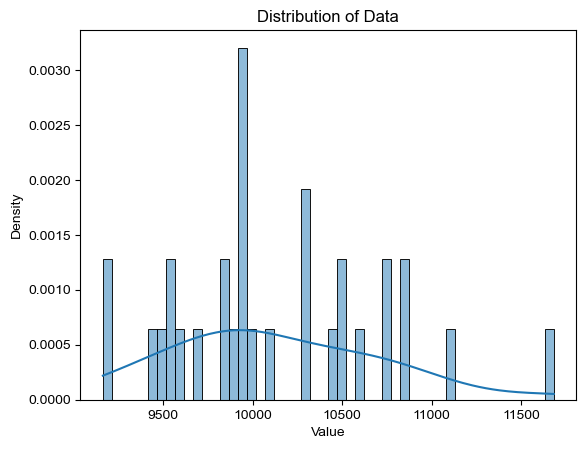

Best fit distribution: gamma (p = 0.8745)
All results:
norm: p = 0.4435
expon: p = 0.0371
lognorm: p = 0.8350
gamma: p = 0.8745
beta: p = 0.8431
uniform: p = 0.0257
the_success_record_array [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
success_rate: 0.62
Total: 63.50 GB
Available: 35.75 GB
Used: 27.76 GB
Percentage usage: 43.7%


In [36]:
dynamic_mode='off' # varying N situation to be considered ('on') or not ('off')
N_i=10 # when dynamic mode is 'on', what is the initial total number of population?
grad_var=0.5 # refer to Gompez model for population growth curve
lag_var=100 # until to what generation does the lag phase end?
algebra_type='integer'
initial_algebra_array=[0]
objective_algebra=1346
#initial_algebra:
#two_array [((0,0),)]
#modulo or list form [((0,0,0,0),)]
#RPS form [('R'),('P'),('S')]
#matrix form [((1,0),(0,1))]
#integer form [1]

#objective_algebra:
#matrix form [[5,2],[6,3]]
#two_array [((2,0),)]
#integer 1346

#regime_array=[1,1,1,1]#concurrent, successional, between, drift : here, 1 turns on any particular regime you choose to be analyzed
iteration_size=50 #total iteration numberpar_
directory="C:/Users/hpdkb/Desktop/Ev/2nd/data/final/"
draw_iter_array=[0,0,0,0]# how many iterations for drawing should be done for each of the concurrent, successional, between, drift regime? 0 means 1 drawing, 1 means 2 drawings, and so on


n_array=[10**6, 10**8] 
m_array=[2*10**(-6)]
s_array=[0.01, 0.02, 0.03, 0.1]
g_array=[30]
#g_array=[2000,4000,6000,8000,10000,12000]
i_array=[1] # how many initial mutations existing in the first place?
regime_array=[1,1,0,0]
core_variable_array=[[10**7, 1e-07, 0.02, 13002, 1, 'concurrent']]
#[[10**7, 3e-06, 0.03, 850, 1, 'concurrent'],[10**7, 3e-09, 0.03, 26006, 1, 'successional'], [10**7, 1e-09, 0.03, 40006, 1, 'successional'], [10**7, 5e-10, 0.03, 60006, 1, 'successional'], [10**7, 3e-10, 0.03, 100006, 1, 'successional'], [10**7, 1e-10, 0.03, 200006, 1, 'successional']]
#core_variable_array_maker(n_array, m_array, s_array, g_array, i_array, regime_array)
print(core_variable_array)

statistical_info(objective_algebra, algebra_type, initial_algebra_array, draw_iter_array, iteration_size, core_variable_array, directory, prime_set, prime_set_initial, N_i,grad_var,lag_var,dynamic_mode)
#lastlast

In [ ]:
[10**7, 5e-07, 0.03, 806, 1, 'concurrent'],[10**7, 3e-07, 0.03, 1306, 1, 'concurrent'],
                    [10**7, 1e-07, 0.03, 1406, 1, 'concurrent'],[10**7, 5e-08, 0.03, 1606, 1, 'concurrent'],[10**7, 3e-08, 0.03, 2006, 1, 'successional'],[10**7, 1e-08, 0.03, 3006, 1, 'successional'],[10**7, 5e-09, 0.03, 6006, 1, 'successional'],
                    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# Define your function here
def fitness(x):
    return (-1/60)*(((x-1)**2)*((x-5)**2)-1/4*((x-5)**2))+1.5  # Change this to any valid NumPy-compatible function

directory1="C:/Users/hpdkb/Desktop/Ev/2nd/data/3/1"

def the_potential(x):
    return -fitness(x)+max(fitness(x))

# Create an array of x values
x = np.linspace(0, 6, 1000)  # Range: [-10, 10], 1000 points
y1 = fitness(x)
y2=the_potential(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y1, label='fiteness(x)', color='blue')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.plot(2, 1.41, 'ro', markersize=10) 
plt.xlim(0, 6)
plt.ylim(1, 1.6)
plt.title('Graph of fitness(x)')
plt.xlabel('x')
plt.ylabel('fitness(x)')
plt.axhline(0, color='black', linewidth=0.5)  # x-axis
plt.axvline(0, color='black', linewidth=0.5)  # y-axis
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.savefig(str(directory1)+'/fitness.png')
plt.show()
plt.close()

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y2, label='the_potential(x)', color='blue')
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.plot(2, 0.2, 'ro', markersize=10) #0.015, 0.133
plt.xlim(0, 6)
plt.ylim(0, 0.6)
plt.title('Graph of potential(x)')
plt.xlabel('x')
plt.ylabel('potential(x)')
plt.axhline(0, color='black', linewidth=0.5)  # x-axis
plt.axvline(0, color='black', linewidth=0.5)  # y-axis
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.savefig(str(directory1)+'/potential.png')
plt.show()
plt.close()

In [ ]:
array=[[0,0,0],[1,0,0.5],[0,1,0.8],[2,0,2.5],[0,2,2],[1,1,-0.5],[2,1,2.1],[1,2,2.2],[2,2,2.3]]#,[3,0,0],[3,1,0],[3,2,0],[3,3,0],[2,3,0],[1,3,0],[0,3,0]]
directory1="C:/Users/hpdkb/Desktop/Ev/2nd/data/3"
x_array=[]
y_array=[]
z_array=[]

for element in array:
    x_array.append(element[0])
    y_array.append(element[1])
    z_array.append(element[2])

#size_array=the_size_decider(values)
#print("size_array", size_array) #bkm

new_array=two_array_up_pyramid(x_array, y_array, z_array)
summed_function={((0,0),):[1,0]}
the_vertices=make_the_vertices(summed_function, new_array)



# Build all pillars
pillar_data=new_array
all_shapes = []
for element in pillar_data:
    x=element[0]
    y=element[1]
    z=element[2]
    mesh, lines = create_cuboid_with_top(x, y, z)
    all_shapes.extend([mesh, lines])


# Extract their top (x, y, z) positions
x_red, y_red, z_red = [], [], []
for x, y, z in the_vertices:
    x_red.append(x)
    y_red.append(y)
    z_red.append(z)  # z = height of the pillar
#print(z_red)
z_red[0]+=0.15

# Add red balls
red_balls = go.Scatter3d(
    x=x_red,
    y=y_red,
    z=z_red,
    mode='markers',
    marker=dict(size=10, color='red', symbol='circle'),
    name='the_state'
)


# Add to the shapes list
all_shapes.append(red_balls)
# Plot
fig = go.Figure(data=all_shapes)
fig.update_layout(
    title='Potential',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Potential',
        aspectmode='data'
    ),
    margin=dict(l=10, r=10, b=10, t=30)
)

#fig.write_image(str(directory1)+'/2d_potential.png')
fig.show()

